In [417]:
# Two examples of learning a covariance dictionary from simulated data with ALS 
# and ADMM, with and without sampling noise.

In [23]:
# Set-up plotting.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context('notebook')

In [357]:
import sys
import time
from numpy import (arange, argmax, argsort, corrcoef, cov, diag, diag_indices, dot, empty, floor, 
                   hsplit, hstack, max, roll, triu_indices, vstack, zeros)
from numpy.linalg import norm
from numpy.random import multivariate_normal, rand, randn
from scipy.linalg import eigh

In [352]:
# Simulated example without sampling noise.

# Inputs
# ------
# X (= D x W) : [n_pair, n_sample] array where each column is the upper 
#     triangle of a covariance matrix
#
# Outputs
# -------
# D : [n_pair, k] array where each column, or dictionary element,
#     is the upper triangle of a covariance matrix
# W : [k, n_sample] array whose (i, j) entry is the weight
#     of the i-th dictionary element in reconstructing the j-th input covariance matrix

# Create example.
n = 100 # number of neurons
k = 4 # number of dictionary elements

# Generate structured weights...
chk_len = 50
shift = 0.75 
n_cov = int(chk_len + (k - 1) * shift * chk_len) # number of input covariances
x = arange(chk_len) / float(chk_len)
template = 20 * hstack((-(x - 0.5) ** 2 + 0.3, zeros((k - 1) * chk_len)))
W = vstack([roll(template, int(i * shift * chk_len)) for i in range(k)])
W = W[:, : n_cov]

# ...and random covariance dictionary as ground truth.
D = vstack([cov(randn(n, n))[triu_indices(n)] for i in range(k)]).T

# Simulate covariance over time.
X = dot(D, W)

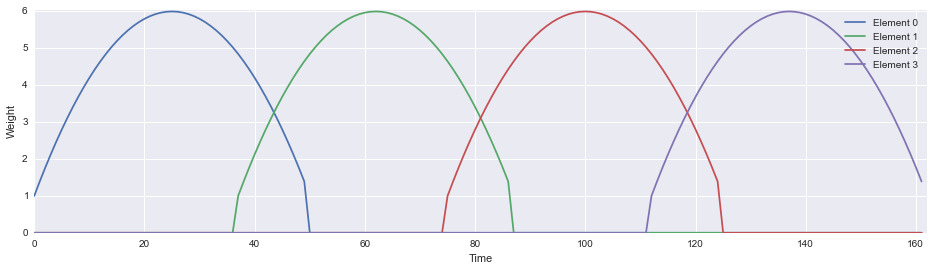

In [353]:
# Plot weights of each dictionary element over time.
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));
plt.plot(W.T);

plt.xlim(0, n_cov);
plt.ylim(0, max(W) + 0.05);
plt.xlabel('Time');
plt.ylabel('Weight');
plt.legend(['Element ' + str(i) for i in range(k)]);

Initial gradient norm: 186.848027.
Iter: 0. Projected gradient norm: 186.847284. Objective: 0.713159.
Iter: 8. Final projected gradient norm 0.001730. Final objective 0.000028.
4.11085295677 seconds


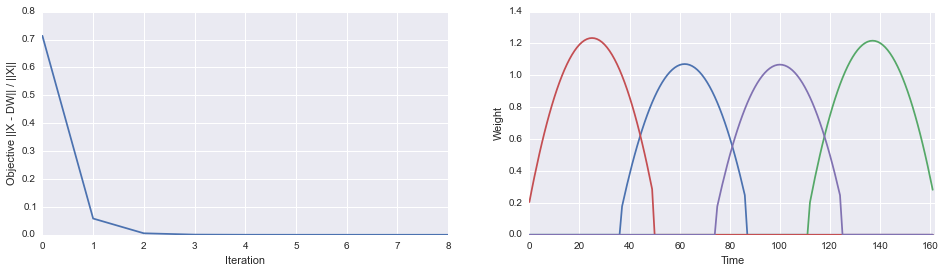

In [301]:
# Learn dictionary using ALS.
reload(covdict)

# Convergence quite sensitive to the beta search parameters for step size.
als = covdict.CovarianceDictionary(k=k, method='als', verbose=True, time=True, nls_beta=0.1, psdls_beta=0.1)
t = time.time()
Wals = als.fit_transform(X)
print str(time.time() - t) + ' seconds'

# Plot objective at each iteration and final learned weights.
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(als.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wals.T);
plt.xlim(0, n_samp);
plt.xlabel('Time');
plt.ylabel('Weight');

In [302]:
# Match ALS-recovered and true dictionary elements.
match_idx = argsort(argmax(Wals, axis=1))

# Correlate to measure accuracy to account for scale factor.
for a, b in zip(als.dictionary[:, match_idx].T, D.T):
    print corrcoef(a, b)[0, 1]

0.999999993741
0.999999999905
0.999999999921
0.999999916711


Iter: 0. Objective: 0.713159.
Iter: 500. Objective: 0.048937.
Iter: 794. Objective: 0.035098.
18.2851879597 seconds


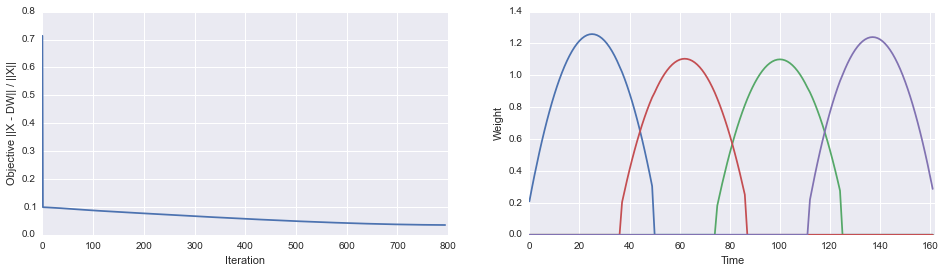

In [303]:
# Learn dictionary using ADMM.
reload(covdict)

# Convergence quite sensitive to gamma step size parameter.
admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True, admm_gamma=0.2)
t = time.time()
Wadmm = admm.fit_transform(X)
print str(time.time() - t) + ' seconds'

# Plot objective at each iteration and final learned weights.
# Well-established linear convergence of ADMM is obvious.
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(admm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wadmm.T);
plt.xlim(0, n_samp);
plt.xlabel('Time');
plt.ylabel('Weight');

In [304]:
# Match ADMM-recovered and corresponding true dictionary elements.
match_idx = argsort(argmax(Wadmm, axis=1))

# Correlate to measure accuracy to account for scale factor.
for a, b in zip(admm.dictionary[:, match_idx].T, D.T):
    print corrcoef(a, b)[0, 1]

0.999732350075
0.999521177867
0.99959358324
0.999733862347


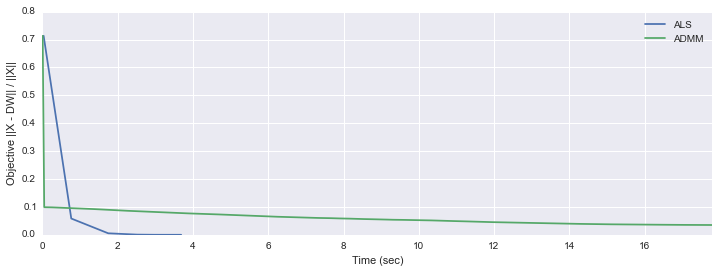

In [305]:
# Compare objectives over time for ALS and ADMM (instead of per iteration).
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4));
plt.plot(als.times, als.objective);
plt.plot(admm.times, admm.objective);
plt.xlim(0, max((admm.times[-1], als.times[-1])));
plt.xlabel('Time (sec)');
plt.ylabel('Objective ||X - DW|| / ||X||');
plt.legend(['ALS', 'ADMM']);

In [409]:
# Simulated example with sampling noise from multivariate Gaussian data.

# Draw samples using previously generated covariances.
n_samp = 2 * n # number of samples drawn per covariance matrix

# Reforms vector into upper triangle of symmetric matrix.
def reform(triu):
    tmp = zeros((n, n))
    tmp[triu_indices(n)] = triu
    c = tmp + tmp.T
    c[diag_indices(n)] = tmp[diag_indices(n)]
    return c

# Ignore non-PSD warnings due to numerical error (negative eigenvalues on order of 1e-17).
data = hstack([multivariate_normal(zeros(n), reform(X[:, i]), n_samp).T for i in range(n_cov)])

# Compute sample covariance matrices.
Xsample = vstack([cov(chunk)[triu_indices(n)] for chunk in hsplit(data, n_cov)]).T

/Users/fannjiangc/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:15: RuntimeWarning: covariance is not positive-semidefinite.


Initial gradient norm: 5239.147209.
Iter: 0. Projected gradient norm: 5239.147209. Objective: 0.988500.
Iter: 2. Final projected gradient norm 0.051783. Final objective 0.384151.
1.90165996552 seconds


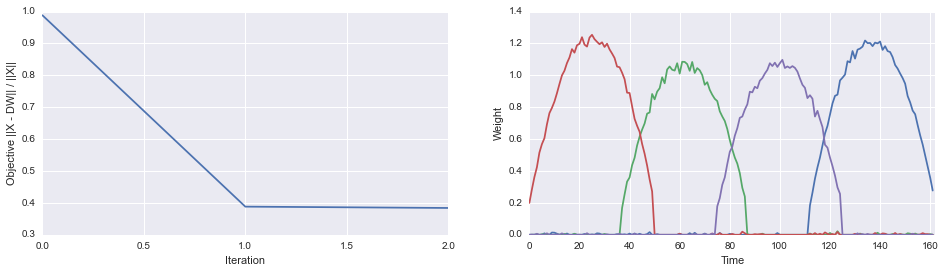

In [412]:
# Learn dictionary using ALS.
reload(covdict)

# Convergence quite sensitive to the beta search parameters for step size.
als = covdict.CovarianceDictionary(k=k, method='als', verbose=True, time=True, nls_beta=0.25, psdls_beta=0.25)
t = time.time()
Wals = als.fit_transform(Xsample)
print str(time.time() - t) + ' seconds'

# Plot objective at each iteration and final learned weights.
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(als.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wals.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');

In [413]:
# Match ALS-learned and true dictionary elements.
match_idx = argsort(argmax(Wals, axis=1))

# Correlate to measure accuracy to account for scale factor.
print "Correlations between ALS-learned and true dictionary elements:"
for a, b in zip(als.dictionary[:, match_idx].T, D.T):
    print corrcoef(a, b)[0, 1]

Correlations between ALS-learned and true dictionary elements:
0.997563728119
0.997285214577
0.99714951618
0.997563975863


Iter: 0. Objective: 0.988500.
Iter: 3. Objective: 0.395049.
0.451257944107 seconds


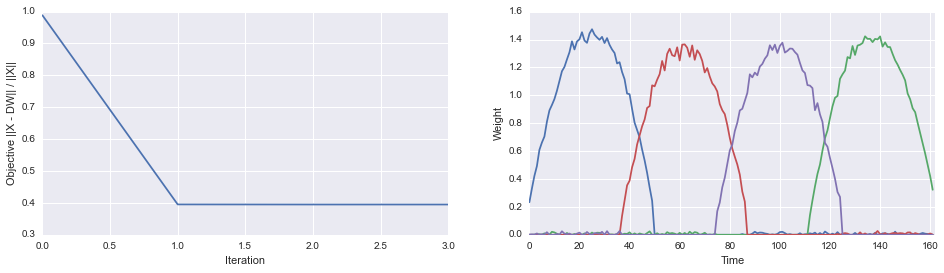

In [414]:
# Learn dictionary using ADMM.
reload(covdict)

admm = covdict.CovarianceDictionary(k=k, method='admm', verbose=True, time=True)
t = time.time()
Wadmm = admm.fit_transform(Xsample)
print str(time.time() - t) + ' seconds'

# Plot objective at each iteration and final learned weights.
# Well-established linear convergence of ADMM is obvious.
sns.set_style('darkgrid')
plt.figure(figsize=(16, 4));

plt.subplot(121);
plt.plot(admm.objective);
plt.xlabel('Iteration');
plt.ylabel('Objective ||X - DW|| / ||X||');

plt.subplot(122);
plt.plot(Wadmm.T);
plt.xlim(0, n_cov);
plt.xlabel('Time');
plt.ylabel('Weight');

In [415]:
# Match ADMM-learned and corresponding true dictionary elements.
match_idx = argsort(argmax(Wadmm, axis=1))

# Correlate to measure accuracy to account for scale factor.
print "Correlations between ADMM-learned and true dictionary elements:"
for a, b in zip(admm.dictionary[:, match_idx].T, D.T):
    print corrcoef(a, b)[0, 1]

Correlations between ADMM-learned and true dictionary elements:
0.996394614745
0.994769259941
0.993938563981
0.996616331957


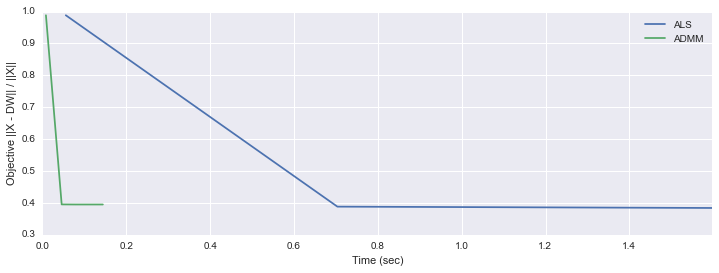

In [416]:
# Compare objectives over time for ALS and ADMM (instead of per iteration).
sns.set_style('darkgrid')
plt.figure(figsize=(12, 4));
plt.plot(als.times, als.objective);
plt.plot(admm.times, admm.objective);
plt.xlim(0, max((admm.times[-1], als.times[-1])));
plt.xlabel('Time (sec)');
plt.ylabel('Objective ||X - DW|| / ||X||');
plt.legend(['ALS', 'ADMM']);